In [1]:
import arviz
import bambi
import numpy
import pandas

from matplotlib import pyplot

In [2]:
_BASE_SEED = "Welcome back to the stage of history. It's CHAPTER NIIIIIIINE."

def fresh_prng(seed: str):
    return numpy.random.default_rng(seed=abs(hash(_BASE_SEED + seed)) % (2 ** 32))

## 9.2, Predictive simulation for linear regression

> Using data of interest to you, fit a linear regression.  Use the output from
> this model to simulate a predictive distribution for observations with a
> particular combination of levels of all the predictors in the regression.

In [3]:
nfl_rng = fresh_prng("Exercise 9.2")

In [4]:
# My fantasy football points dataset:
nfl_df = pandas.read_csv('/home/bgawalt/ros/datasets/nfl_idp_scores.csv')
nfl_df = nfl_df[(nfl_df.idp_2023 > 20) & (nfl_df.idp_2024 > 20)]
nfl_df["log_idp_2023"] = nfl_df.idp_2023.apply(numpy.log)
nfl_df["log_idp_2024"] = nfl_df.idp_2024.apply(numpy.log)
nfl_df.describe()

,idp_2023,idp_2024,log_idp_2023,log_idp_2024
count,735.000000,735.000000,735.000000,735.000000
mean,107.330000,102.587565,4.466192,4.422317
std,69.806404,68.443590,0.666514,0.659109
min,20.250000,20.060000,3.008155,2.998728
25%,53.000000,52.125000,3.970292,3.953642
50%,94.000000,88.500000,4.543295,4.483003
75%,143.250000,131.225000,4.964591,4.876913
max,406.700000,441.380000,6.008076,6.089906


In [5]:
# Fit the model
nfl_model = bambi.Model("log_idp_2024 ~ log_idp_2023", nfl_df)
nfl_fit = nfl_model.fit()
arviz.summary(nfl_fit, var_names="~mu")

Initializing NUTS using jitter+adapt_diag...
/home/bgawalt/venv/ros/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, log_idp_2023]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/home/bgawalt/venv/ros/lib/python3.10/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['mu'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.535,0.014,0.510,0.561,0.000,0.000,6278.0,3121.0,1.0
Intercept,1.835,0.131,1.614,2.098,0.002,0.002,6307.0,3178.0,1.0
log_idp_2023,0.579,0.029,0.525,0.632,0.000,0.000,6161.0,3272.0,1.0


In [6]:
p25_preds = []  # Point predictions for a 25%-ile player, log IDP 3.97
p50_preds = []  # Point predictions for a 50%-ile player, log IDP 4.54
p75_preds = []  # Point predictions for a 50%-ile player, log IDP 4.96
sigmas = []
for chain in range(4):
    chain_df = (
        nfl_fit.posterior.sel(chain=chain).to_dataframe().groupby("draw").mean())
    p25_preds.extend(chain_df.apply(lambda row: row["Intercept"] + row["log_idp_2023"] * 3.97, axis=1).to_list())
    p50_preds.extend(chain_df.apply(lambda row: row["Intercept"] + row["log_idp_2023"] * 4.54, axis=1).to_list())
    p75_preds.extend(chain_df.apply(lambda row: row["Intercept"] + row["log_idp_2023"] * 4.96, axis=1).to_list())
    sigmas.extend(chain_df["sigma"].to_list())
p25_dist = numpy.array(p25_preds) + nfl_rng.normal([0.0 for _ in p25_preds], sigmas)
p50_dist = numpy.array(p50_preds) + nfl_rng.normal([0.0 for _ in p50_preds], sigmas)
p75_dist = numpy.array(p75_preds) + nfl_rng.normal([0.0 for _ in p75_preds], sigmas)

Text(0.5, 0, 'Predicted IDP Score, 2024 (log scale)')

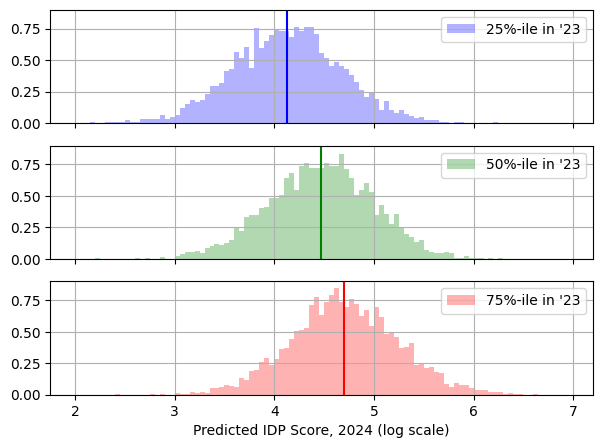

In [7]:
bins = numpy.arange(2, 7, 0.05)

fig, axs = pyplot.subplots(nrows=3, ncols=1, sharex=True, figsize=(7, 5))
axs[0].hist(p25_dist, bins=bins, color='b', label="25%-ile in '23", alpha=0.3, density=True)
axs[0].axvline(x=p25_dist.mean(), color='b')
axs[1].hist(p50_dist, bins=bins, color='g', label="50%-ile in '23", alpha=0.3, density=True)
axs[1].axvline(x=p50_dist.mean(), color='g')
axs[2].hist(p75_dist, bins=bins, color='r', label="75%-ile in '23", alpha=0.3, density=True)
axs[2].axvline(x=p75_dist.mean(), color='r')
for ax in axs:
    ax.grid()
    ax.set_ylim(0, 0.9)
    ax.legend()
ax.set_xlabel("Predicted IDP Score, 2024 (log scale)")

(0.0, 400.0)

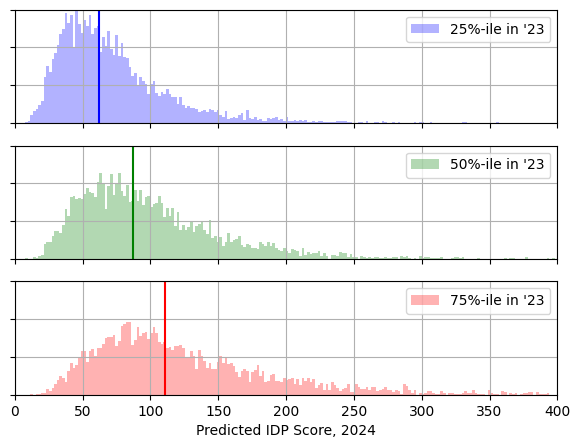

In [8]:
bins = numpy.arange(numpy.exp(2), 400, (400 - numpy.exp(2))/200)

fig, axs = pyplot.subplots(nrows=3, ncols=1, sharex=True, figsize=(7, 5))
axs[0].hist(numpy.exp(p25_dist), bins=bins, color='b', label="25%-ile in '23", alpha=0.3, density=True)
axs[0].axvline(x=numpy.exp(p25_dist.mean()), color='b')
axs[1].hist(numpy.exp(p50_dist), bins=bins, color='g', label="50%-ile in '23", alpha=0.3, density=True)
axs[1].axvline(x=numpy.exp(p50_dist.mean()), color='g')
axs[2].hist(numpy.exp(p75_dist), bins=bins, color='r', label="75%-ile in '23", alpha=0.3, density=True)
axs[2].axvline(x=numpy.exp(p75_dist.mean()), color='r')
for ax in axs:
    ax.grid()
    ax.set_ylim(0, 0.015)
    ax.set_yticklabels([])
    ax.legend()
ax.set_xlabel("Predicted IDP Score, 2024")
ax.set_xlim(0, 400)

## Scratch:

DELETE ME

In [9]:
rng = numpy.random.default_rng(1211)

size = 100
true_intercept = 1
true_slope = 2

x = numpy.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

# Add outliers
x_out = numpy.append(x, [0.1, 0.15, 0.2])
y_out = numpy.append(y, [8, 6, 9])

data = pandas.DataFrame({"baby_jesus": x_out,  "y": y_out})

In [10]:
gauss_model = bambi.Model("y ~ baby_jesus", data, family="gaussian")
gauss_fitted = gauss_model.fit()  #idata_kwargs={"log_likelihood": True})
print("HI MOM")
print(gauss_model.predict(gauss_fitted, kind="response"))

Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, baby_jesus]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


HI MOM
None


In [11]:
arviz.summary(gauss_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.222,0.087,1.070,1.393,0.001,0.001,5116.0,3329.0,1.0
Intercept,1.511,0.231,1.065,1.927,0.003,0.004,5699.0,3192.0,1.0
baby_jesus,1.147,0.415,0.335,1.895,0.006,0.006,5438.0,2981.0,1.0
mu[0],1.511,0.231,1.065,1.927,0.003,0.004,5699.0,3192.0,1.0
mu[1],1.523,0.227,1.093,1.941,0.003,0.004,5702.0,3193.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[98],2.647,0.242,2.162,3.088,0.003,0.004,5312.0,3283.0,1.0
mu[99],2.659,0.246,2.176,3.113,0.003,0.004,5302.0,3299.0,1.0
mu[100],1.626,0.196,1.242,1.978,0.003,0.003,5759.0,3344.0,1.0
mu[101],1.683,0.180,1.345,2.021,0.002,0.003,5794.0,3405.0,1.0


In [12]:
gary = gauss_fitted.posterior.sel(chain=1).to_dataframe().groupby(by="draw").mean()

In [13]:
for i, a in enumerate(gary["baby_jesus"]["sigma"]):
    print(i, a)
    if i == 5:
        break

KeyError: 'sigma'